In [1]:
from utils import set_pyplot_params
set_pyplot_params()

# Testing

In un capitolo precedente abbiamo visto il problema dell'euro che citiamo qui sotto

> Quando lanciamo l'euro Belga 250 volte, otteniamo 140 volte testa e 110 coda. Sembra sospetto secondo Barry Blight, uno statistico della scuola di Economia di Londra. `Se la moneta non è truccata la possibilità di ottenere un risultato così estremo dovrebbe essere minore del 7%.`

Ci chiediamo questo dato ci da evidenza che la moneta è truccata o meno ?

Siamo partiti a rispondere a questa domanda basandosi su queste decisioni si modellazione:

* Se lanciamo una moneta c'è una certa probabilità, $x$, che questa dia il risultato testa. 
* Il valore di $x$ varia da una moneta all'altra, a seconda di come la moneta è bilanciata e possibilmente da altri fattori.

Partendo con una distribuzione a prori di $x$, abbiamo aggiornato la distribuzione dei dati, 140 teste e 110 code. Poi abbiamo usato la distribuzione a posteriori per calcolare la probabilità più probabile (la media della distribuzione) e un intervallo di credibilità.

Ma non abbiamo realmente risposto alla domanda di MacKay. "Questo ci da evidenza che questa moneta sia truccata o meno?"
In questo capitolo, finalmente, avremo una risposta.

## Stime
Ricapitoliamo la soluzione del problema dell'Euro. 
Siamo partiti dalla distribuzione a priori uniforme.


In [2]:
import numpy as np
from distribution import Pmf

xs = np.linspace(0, 1, 101)
uniform = Pmf(1, xs)

Abbiamo usato la distribuzione binomaile per calcolare la probabilità dei dati per ogni valore di $x$.

In [3]:
from scipy.stats import binom

k, n = 140, 250
likelihood = binom.pmf(k, n, xs)

Abbiamo calcolato la distribuzione a posteriori nel modo usuale.

In [4]:
posterior = uniform * likelihood
posterior.normalize()

0.3984063745019918

E questo il risultato

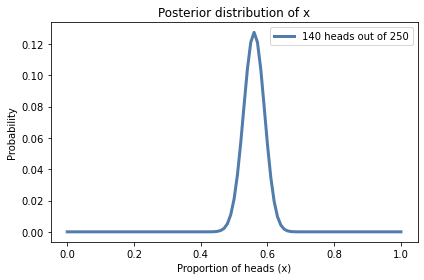

In [5]:
from utils import decorate

posterior.plot(label='140 heads out of 250')

decorate(xlabel='Proportion of heads (x)',
         ylabel='Probability',
         title='Posterior distribution of x')

Ancora, la media della distribuzione a posteriori è di circa 0.56, con il 90% dell'intervallo di credibilità dal 0.51 al 0.61.

In [6]:
posterior.mean(), posterior.credible_interval(0.9)

(0.5595238095238094, array([0.51, 0.61]))

La media della distribuzione a priori è 0.5, mentre la media a posteriori è 0.56, sembra ci sia l'evidenza che questa moneta sia truccata.

Ma, questo non è così semplice.

## Evidenza
Nel problema di Oliver, abbiamo detto che i dati sono evidenza in favore delle ipotesi, $A$, se i dati sono più probabili sotto l'ipotesi $A$ piuttosto che sotto l'alternativa, $B$; come scritto qui sotto:

$$P(D|A) > P(D|B)$$

Inoltre, possiamo quantificare la forza della evidenza calcolando il rapporto di queste verosomiglianze, che è conosciuto anche come  [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor) e spesso denotato come $K$:

$$K = \frac{P(D|A)}{P(D|B)}$$

Dunque per il problema dell'euro consideriamo due ipotesi, `fair` e `biased`, e calcoliamo la verosomiglianza del dato sotto ogni ipotesi.

Se la moneta è truccata, la probabilità di ottenere testa è del 50%, possiamo calcolare la probabilità del dato (140 teste su 250 lanci) usando la distribuzione binomiale:



In [7]:
k = 140
n = 250

like_fair = binom.pmf(k, n, p=0.5)
like_fair

0.008357181724918204

Questa è la probabilità del dato dato il fatto che la moneta non è truccata.
Ma se la moneta è truccata, quale è la probabilità del dato?. Questo dipende su cosa significa "truccato".
Se conosciamo a priori che truccato significa che la probabilità di ottenere testa è del 56%. Possiamo usare la distribuzione binomiale ancora:



In [8]:
like_biased = binom.pmf(k, n, p=0.56)
like_biased

0.05077815959518339

Possiamo calcolare il rapporto delle verosomiglianze:

In [9]:
K = like_biased / like_fair
K

6.075990838368468

Il dato è circa 6 volte più probabile se la moneta è truccata, per definizione, piuttosto che non truccata.
Ma se usiamo i dati per definire le ipotesi, ci sembra di imbrogliare. Per essere corretti, dobbiamo definire "truccato" prima di vedere il dato. 

## Bias distribuito uniformemente
Supponiamo che "truccato" significa che la probabilità di ottenere testa sia un valore diverso da 50%, e tutti gli altri valori sono ugualmente distribuiti.

Possiamo rappresentare questa definizione, facendo una distribuzione uniforme e rimuovendo il valore 50%.


In [10]:
biased_uniform = uniform.copy()
biased_uniform[0.5] = 0
biased_uniform.normalize()

100

Per calcolare la probabilità totale del dato sotto questa ipotesi, possiamo calcolare la probabilità condizionale del dato sotto ogni ipotesi di x.



In [11]:
xs = biased_uniform.qs
likelihood = binom.pmf(k, n, xs)

Poi moltiplichiamo queste probabilità e sommiamo i prodotti:

In [12]:
like_uniform = np.sum(biased_uniform * likelihood)
like_uniform

0.003900491927770735

Dunque questa è la probabilità del dato sotto l'ipotesi di "bias uniforme".
Ora possiamo calcolare la probabilità del rapporto del dato tra le due ipotesi `fair` e `biased uniform`:

In [13]:
K = like_fair / like_uniform
K

2.1425968518013625

Il dato dice che la moneta è duce volte più probabile se la moneta è non truccata piuttosto che truccata, per questa definizione di truccato.

Per avere un senso di quanto forte sia l'evidenza, possiamo applicare la regola di Bayes. Per esempio, se la probabilità a priori che la moneta sia truccata è 50%, il rapporto a priori è 1, dunque se il rapporto a posteriori e di circa 2.1 la probabilità a posteriori è del 68%.



In [14]:
prior_odds = 1
posterior_odds = prior_odds * K
posterior_odds

2.1425968518013625

In [15]:
def prob(o):
    return o / (o+1)

In [16]:
posterior_probability = prob(posterior_odds)
posterior_probability

0.6817918278551092

L'evidenza che "muove l'ago" dal 50% al 68% non è molto forte.

Ora supponiamo che "biased" non significa che tutti i valori di x sono egualmente distribuiti.
Potrebbe essere che i valori vicini al 50% siano più probabili e i valori agli estremi siano meno probabili. Possiamo usare una distribuzione di forma triangolare per rappresentare questa definizione alternativa di "biased": 

In [17]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)
a = np.append(ramp_up, ramp_down)

triangle = Pmf(a, xs, name='triangle')
triangle.normalize()

2500

Come fatto per la distribuzione uniforme, possiamo rimuovere il valore 50% come possibile valore di $x$ (questo non fa molta differenza se viene trascurato).

In [18]:
biased_triangle = triangle.copy()
biased_triangle[0.5] = 0
biased_triangle.normalize()

0.98

Qui un grafico delle due distribuzioni:

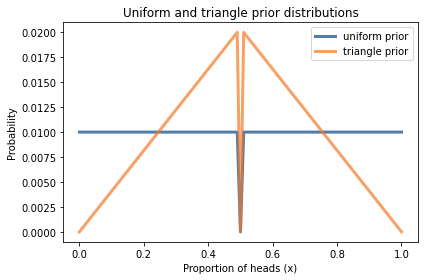

In [19]:
biased_uniform.plot(label='uniform prior')
biased_triangle.plot(label='triangle prior')

decorate(xlabel='Proportion of heads (x)',
         ylabel='Probability',
         title='Uniform and triangle prior distributions')

In [20]:
like_triangle = np.sum(biased_triangle * likelihood)
like_triangle

0.00698132546485788

In [21]:
K = like_fair / like_triangle
K

1.1970766535647157

In [22]:
posterior_probability = prob(K)
posterior_probability

0.5448497446015282

## Test di ipotesi bayesiano

Quello che abbiamo appena fatto in questo capitolo è un qualcosa chiamato "Test di ipotesi bayesiano" in contrasto con con [il test delle ipotesi statistico](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing).

Nel statistico delle ipotesi, calcoliamo il p-value, che è difficile da definire in modo coinciso, e lo usiamo per determinare se i risultati sono "statisticamente significatici", anche questo è difficile da definire.

La sua alternativa bayesiana è quella di riportare il fattore di Bayes, $K$, che riassume la forza della evidenza in favore una delle ipotesi o l'altra. 

Alcune persone pensano sia meglio di riportare $K$ piuttosto che la probabilità a posteriori perchè $K$ non dipende dalla probabilità a priori.

Ma come abbiamo detto in questo esempio, $K$ dipende da una definizione precisa delle ipotesi, che può essere controversa quanto la probabilità a priori.


## Bayesian Bandits
Se sei mai stato in un casinò, hai probabilmente visto una slot machine, che qualche volta vengono chiamate anche "one-armed bandit" perchè ha una maniglia che sembra un braccio e hanno la capacità di rubarti i soldi come un bandito.

La strategia del Bayesian Bandit risolve un problema basato su una versione semplificato di una slot machine.
Supponiamo che ogni volta che giochi ad una slot machine, c'è una probabilità fissa di vincita.
Supponiamo che differenti macchine abbiano differenti pobabilità di vincita, ma non sappiamo che probabilità abbia.

Inizialmente, abbiamo la stessa credenza su ogni macchina, dunque non abbiamo preferenze specifiche. Ma se giochiamo con ogni macchina un po di tempo, possiamo usare i risultati per stimare le probabilità di vincita. Possiamo usare le stime delle probabilità per decidere su quale macchine giocare.

Ad alto livello, questa è la strategia del Bayesian bandit. Vediamo ora i dettagli.

## Aspettative a priori
Se non sappiamo nulla circa la probabilità di vincita, possiamo partire con una distribuzione a priori uniforme.


In [23]:
xs = np.linspace(0, 1, 101)
prior = Pmf(1, xs)
prior.normalize()

101

Supponiamo di poter scegliere tra tutte le quattro slot machines, Facciamo quattro copie della distribuzione.


In [24]:
beliefs = [prior.copy() for i in range(4)]

Questa funzione mostra poi le distribuzioni in una griglia:

In [25]:
import matplotlib.pyplot as plt

options = dict(xticklabels='invisible', yticklabels='invisible')

def plot(beliefs, **options):
    for i, pmf in enumerate(beliefs):
        plt.subplot(2, 2, i+1)
        pmf.plot(label='Machine %s' % i)
        decorate(yticklabels=[])
        
        if i in [0, 2]:
            decorate(ylabel='PDF')
        
        if i in [2, 3]:
            decorate(xlabel='Probability of winning')
        
    plt.tight_layout()

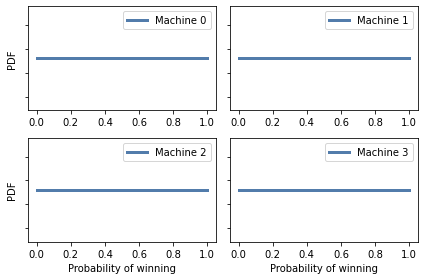

In [26]:
plot(beliefs)

## The Update
Ogni volta che giochiamo con una slot machine, possiamo usare i risultati per aggiornare le nostre credenze.
La seguente funzione fa l'aggiornamento. 

In [27]:
likelihood = {
    'W': xs,
    'L': 1 - xs
}

In [28]:
def update(pmf, data):
    """Update the probability of winning."""
    pmf *= likelihood[data]
    pmf.normalize()

Questa funzione aggiorna la distribuzione in loco.
`pmf` è un oggetto `Pmf` che rappresenta la distribuzione a priori di `x`,che è la probabilità di vincita.
`data` è una stringa, che può essere `W` se il risultato è una vincita oppure `L` se il risultato è una perdita.
La verosomiglianza del dato può essere `xs` o `1-xs`, in base al risultato.

Supponiamo di scegliere una macchina e di giocarci 10 volte e di vincere una volta. Possiamo calcolare la distribuzione a posteriori di `x`, basandosi su questo risultato come questa:

In [29]:
np.random.seed(17)

In [30]:
bandit = prior.copy()

for outcome in 'WLLLLLLLLL':
    update(bandit, outcome)

Qui la visualizzazione della distribuzione a posteriori.

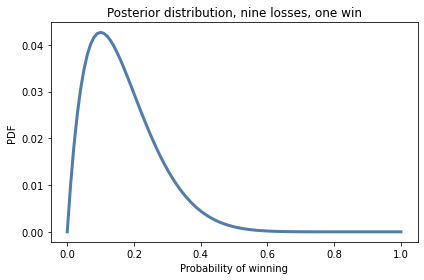

In [31]:
bandit.plot()
decorate(xlabel='Probability of winning',
         ylabel='PDF',
         title='Posterior distribution, nine losses, one win')

## Multiple Bandits
Ora supponiamo di avere queste quattro macchine con queste probabilità:

In [32]:
actual_probs = [0.10, 0.20, 0.30, 0.40]

Ovviamente da giocatore, non sappiamo queste probabilità.
La seguente funzione prende in ingresso l'indice della macchina, simulando le giocate, e ritorna il risultato  `W` o `L`.



In [33]:
from collections import Counter

# count how many times we've played each machine
counter = Counter()

def play(i):
    """Play machine i.
    
    i: index of the machine to play
    
    returns: string 'W' or 'L'
    """
    counter[i] += 1
    p = actual_probs[i]
    if np.random.random() < p:
        return 'W'
    else:
        return 'L'

La variabile `counter` è un oggetto `Counter`, che è una specie di dizionario che useremo per tenere traccia di quante volte ogni macchina è usata.
Questo è il risultato del testo dopo le 10 giocate.

In [34]:
for i in range(4):
    for _ in range(10):
        outcome = play(i)
        update(beliefs[i], outcome)

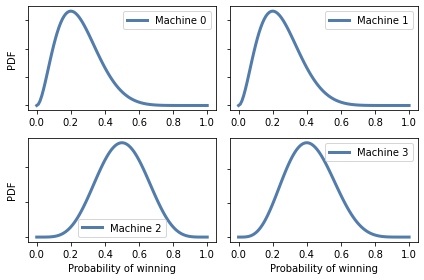

In [35]:
plot(beliefs)

Qui le probabilità attuali, la media a posteriori e il 90% dell'intervallo di credibilità.

In [36]:
import pandas as pd

def summarize_beliefs(beliefs):
    """Compute means and credible intervals.
    
    beliefs: sequence of Pmf
    
    returns: DataFrame
    """
    columns = ['Actual P(win)', 
               'Posterior mean', 
               'Credible interval']
    
    df = pd.DataFrame(columns=columns)
    for i, b in enumerate(beliefs):
        mean = np.round(b.mean(), 3)
        ci = b.credible_interval(0.9)
        ci = np.round(ci, 3)
        df.loc[i] = actual_probs[i], mean, ci
    return df

In [37]:
summarize_beliefs(beliefs)

,Actual P(win),Posterior mean,Credible interval
0,0.1,0.250,"[0.08, 0.47]"
1,0.2,0.250,"[0.08, 0.47]"
2,0.3,0.500,"[0.27, 0.73]"
3,0.4,0.417,"[0.2, 0.65]"


## Esplora o sfrutta

Basandosi sulla distribuzioni a posteriori, su quale macchina pensi sia meglio giocare? Una opzione potrebbe essere quella di scegliere la macchina con la media a posteriori più alta. 

Non sarebbe una cattiva idea, ma ha uno svantaggio: dal momento che abbiamo usato le macchine solo poche volte, le distribuzioni a posteriori sono larghe e sovrapposte, questo significa che non siamo sicuri quale sia la macchina migliore; se ci concentriamo sulla macchina troppo presto, potremmo scegliere la macchina sbagliata e giocare più di quanto dovremmo.

Per ovviare a questo problema, possiamo arrivare all'altro estremo e giocare su tutte le macchine ugualmente finchè non siamo confidenti di aver identificato la miglior macchina. 
Fatto questo si gioca solo con quella.

Anche questa non è una cattiva idea, ma c'è anche qui uno svantaggio: finchè stiamo raccogliendo i dati, non stiamo facendo buon uso dei dati; finchè non siamo sicuri quale macchina sia la migliore, giocheremo con le altre più di quanto serve.

La strategia del Bayesian Bandits evita entrambe gli svantaggi raccogliendo i dati e usandoli allo stesso tempo. In altre parole si bilancia tra esplorazione e sfruttamento.

Il nocciolo dell'idea è [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling): quando scegliamo una macchina, scegliamo a caso in modo che la probabilità di scegliere ogni macchina sia proporzionale alla probabilità che sia la migliore.
Data la distribuzione a posteriori, possiamo calcolare la "probabilità di superiorità" di ogni macchina.

Ecco un modo per farlo. Possiamo scegliere un campione di 1000 valori per ogni distribuzioni a posteriori, come questo:

In [38]:
samples = np.array([b.choice(1000) 
                    for b in beliefs])
samples.shape

(4, 1000)

Il risultato sono 4 righe e 1000 colonne. Possiamo usare `argmax` per trovare l'indice del più grande valore di ogni colonna:

In [39]:
indices = np.argmax(samples, axis=0)
indices.shape

(1000,)

Usiamo `Pmf` di questi indici per scegliere la frazione di tempo in cui ogni macchina ha dato i risultati più alti.

In [40]:
pmf = Pmf.from_seq(indices)
pmf

,probs
0,0.048
1,0.043
2,0.625
3,0.284


In [41]:
pmf.choice()

1

In [42]:
def choose(beliefs):
    """Use Thompson sampling to choose a machine.
    
    Draws a single sample from each distribution.
    
    returns: index of the machine that yielded the highest value
    """
    ps = [b.choice() for b in beliefs]
    return np.argmax(ps)

In [43]:
choose(beliefs)

3

## La strategia

Mettendo tutto assieme, la seguente funzione sceglie una macchina, ci gioca ed aggiorna la variabile `beliefs`:

In [44]:
def choose_play_update(beliefs):
    """Choose a machine, play it, and update beliefs."""
    
    # choose a machine
    machine = choose(beliefs)
    
    # play it
    outcome = play(machine)
    
    # update beliefs
    update(beliefs[machine], outcome)

Per provarla, iniziamo con un nuovo insieme di beliefs e `Counter`.

In [45]:
beliefs = [prior.copy() for i in range(4)]
counter = Counter()

Se eseguiamo l'algortimto 100 volte, possiamo vedere come `beliefs` venga aggiornato:

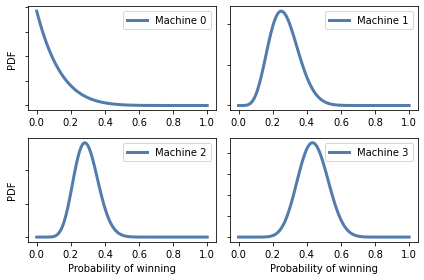

In [46]:
num_plays = 100

for i in range(num_plays):
    choose_play_update(beliefs)
    
plot(beliefs)

In [47]:
summarize_beliefs(beliefs)

,Actual P(win),Posterior mean,Credible interval
0,0.1,0.107,"[0.0, 0.31]"
1,0.2,0.269,"[0.14, 0.42]"
2,0.3,0.293,"[0.18, 0.41]"
3,0.4,0.438,"[0.3, 0.58]"


L'intervallo di credibilità tipicamente contiene le probabilità di vincita attuali.
Le stime sono ancora grezze, specialmente per le macchine con una bassa probabilità di vincita. Ma questo è un punto a favore non uno svantaggio: il nostro obiettivo è quello di usare le slot machine con la più alta probabilità di vincita il numero maggiore di volte. 
Vediamo quante volte ogni volta viene usata.

In [48]:
def summarize_counter(counter):
    """Report the number of times each machine was played.
    
    counter: Collections.Counter
    
    returns: DataFrame
    """
    index = range(4)
    columns = ['Actual P(win)', 'Times played']
    df = pd.DataFrame(index=index, columns=columns)
    for i, count in counter.items():
        df.loc[i] = actual_probs[i], count
    return df

In [49]:
summarize_counter(counter)

,Actual P(win),Times played
0,0.1,7
1,0.2,24
2,0.3,39
3,0.4,30


Se le cose vanno secondo i piani, le macchine con una alta probabilità di vincita verranno usate di più.